In [1]:


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np


In [3]:

train_data = pd.read_csv('Stat_380_train2021.csv', sep=',')
test_data = pd.read_csv('Stat_380_test2021.csv', sep=',')

# Concatenate the train and test dataframes so the preprocessing is applied to both 
full_data = pd.concat([train_data,test_data]).reset_index(drop = True)

sale_price = train_data['SalePrice'].reset_index(drop=True)
# Remove the Sale Price dependent variable from the combined dataset 
del full_data['SalePrice']

print(f'Train dataframe contains {train_data.shape[0]} rows and {train_data.shape[1]} columns.\n')
print(f'Test dataframe contains {test_data.shape[0]} rows and {test_data.shape[1]} columns.\n')
print(f'The merged dataframe contains {full_data.shape[0]} rows and {full_data.shape[1]} columns.')


Train dataframe contains 5000 rows and 15 columns.

Test dataframe contains 5000 rows and 14 columns.

The merged dataframe contains 10000 rows and 14 columns.


In [4]:

cols_to_drop = []
for column in full_data:
  if full_data[column].isnull().sum() / len(full_data) >= 0.4:
    cols_to_drop.append(column)
full_data.drop(cols_to_drop, axis=1, inplace=True)

print(f'{len(cols_to_drop)} columns dropped, the full dataset now comprises of {full_data.shape[1]} variables.')

scaler = MinMaxScaler()

columns = full_data.columns.values
for column in columns:
  if full_data[column].dtype == np.int64 or full_data[column].dtype == np.float64:
    full_data[column] = full_data[column].fillna(full_data[column].median())
    full_data[column] = scaler.fit_transform(np.array(full_data[column]).reshape(-1,1)) #reshape data for model fit



0 columns dropped, the full dataset now comprises of 14 variables.


In [5]:
# Print the updated data  
full_data.head()


,Id,LotFrontage,LotArea,OverallQual,OverallCond,FullBath,HalfBath,TotRmsAbvGrd,YearBuilt,TotalBsmtSF,BedroomAbvGr,GrLivArea,PoolArea,YrSold
0,0.0000,0.167808,0.066737,0.333333,0.625,0.333333,0.0,0.250000,0.707692,0.450405,0.375,0.135882,0.0,1.00
1,0.0002,0.219178,0.036383,0.444444,0.750,0.333333,0.0,0.166667,0.600000,0.334685,0.375,0.186550,0.0,1.00
2,0.0004,0.167808,0.051611,0.333333,0.625,0.666667,0.0,0.250000,0.953846,0.329382,0.375,0.167895,0.0,0.50
3,0.0006,0.195205,0.034392,0.333333,0.500,0.333333,0.0,0.416667,0.961538,0.356207,0.500,0.276601,0.0,0.25
4,0.0008,0.157534,0.033195,0.444444,0.875,0.333333,0.0,0.500000,0.969231,0.438553,0.375,0.303547,0.0,0.00


9 columns dropped, the full dataset now comprises of 5 variables.
0 columns dropped, the full dataset now comprises of 5 variables.


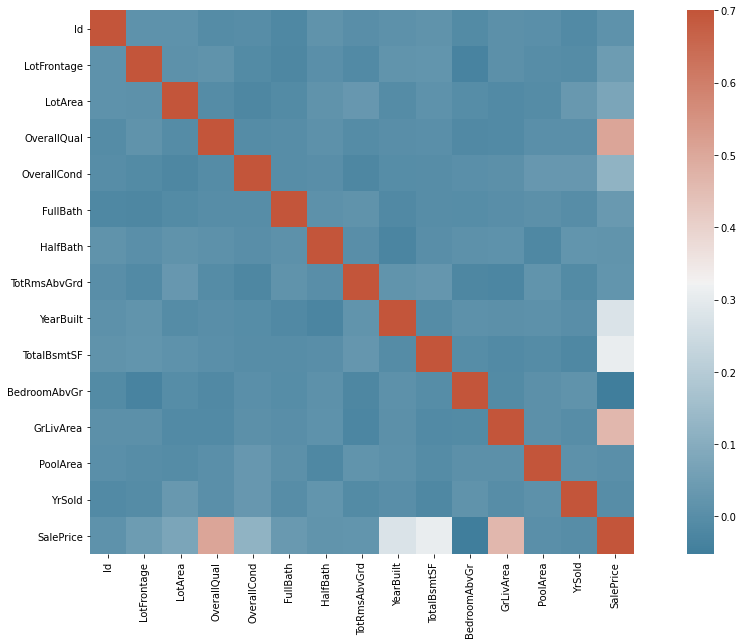

In [6]:

corr = train_data.corr()
plt.subplots(figsize=(19,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, vmax=0.7, cmap = cmap, square=True)

cols_to_drop = []
# Get the correlation of the dependent variable with the rest of the features
sale_price_corr = train_data.corr()['SalePrice'][:-1] 

# Drop all the columns from the full data that correlate < |0.12| with the sale price, 
# since will add little value to the model 
for column,row in sale_price_corr.iteritems():
  if abs(float(row)) < 0.12:
    cols_to_drop.append(column)
full_data.drop(cols_to_drop, axis=1, inplace=True)

print(f'{len(cols_to_drop)} columns dropped, the full dataset now comprises of {full_data.shape[1]} variables.')

count = 0 
columns = full_data.columns.values
for column in columns:
  if full_data[column].dtype not in (np.int64, np.float64) and full_data[column].nunique() > 6:
    count += 1 
    full_data.drop(column, axis = 1, inplace = True)

print(f'{count} columns dropped, the full dataset now comprises of {full_data.shape[1]} variables.')


In [9]:

full_data = full_data.fillna(full_data.mode().iloc[0])

labelencoder = LabelEncoder()
cols_to_drop = []

columns = full_data.columns.values
for column in columns:
    if full_data[column].dtype not in (np.int64, np.float64) and full_data[column].nunique() > 2: 
      dummies = pd.get_dummies(full_data[column], prefix = str(column))
      cols_to_drop.append(column)
      full_data = pd.concat([full_data, dummies], axis = 1)
    elif full_data[column].dtype not in (np.int64, np.float64) and full_data[column].nunique() < 3: 
      full_data[column] = labelencoder.fit_transform(full_data[column])
      cols_to_drop.append(column)

full_data.drop(cols_to_drop, axis = 1, inplace = True)
print(f'The new dataframe comprises of {test_data.shape[0]} rows and {test_data.shape[1]} columns.\n')

train_df = full_data[:train_data.shape[0]]
test_df =  full_data[train_data.shape[0]:]

import tensorflow as tf
#Set random seed
tf.random.set_seed(42)

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(1000), 
                            tf.keras.layers.BatchNormalization(), 
                            tf.keras.layers.Dense(100), 
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.Dropout(0.1), 
                            tf.keras.layers.Dense(1) 
])

# Compile the model


The new dataframe comprises of 5000 rows and 14 columns.



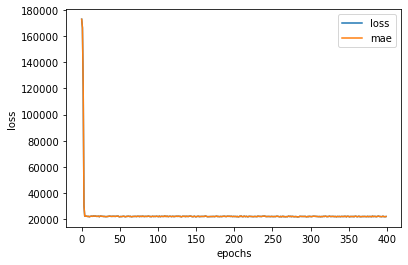

In [10]:
model.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0003), 
                          metrics=['mae'])

# Fit the model and save the history 
history = model.fit(train_df,sale_price, epochs=400, verbose=0)

# Plot the model trained for 400 total epochs loss curves
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()


In [11]:

DNN_predictions = model.predict(test_df)
DNN_predictions = tf.squeeze(DNN_predictions, axis = 1)
DNN_predictions = np.array(DNN_predictions)
DNN_predictions

from xgboost import XGBRegressor

xgboost = XGBRegressor(learning_rate=0.008,
                       n_estimators=6000,
                       max_depth=8,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

xgb = xgboost.fit(train_df,sale_price)
training_accuracy = xgb.score(train_df,sale_price)
print("Training accuracy: %.2f%%" % (training_accuracy * 100.0))
xgb_predictions = xgb.predict(test_df)



Training accuracy: 98.88%


In [ ]:
#Export

predictions = [(xgb_pred + DNN_pred) / 2 for xgb_pred, DNN_pred in zip(xgb_predictions, DNN_predictions)]
submission = pd.DataFrame({'ID':test_data['Id'],'SalePrice':predictions})
submission.to_csv('submission.csv',index = False)
submission